In [10]:
import mne
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

dataset_path = "/Users/manasamiee/Documents/E-HEALTH/DROZY/psg"

edf_files = [
    "1-1.edf", "1-2.edf", "1-3.edf",
    "2-1.edf", "2-2.edf", "2-3.edf",
    "3-1.edf", "3-2.edf", "3-3.edf",
    "4-1.edf", "4-2.edf", "4-3.edf",
    "5-1.edf", "5-2.edf", "5-3.edf",
    "6-1.edf", "6-2.edf", "6-3.edf",
    "7-2.edf", "7-3.edf",  # File 7-1.edf is missing
    "8-1.edf", "8-2.edf", "8-3.edf",
    "9-1.edf", "9-2.edf", "9-3.edf",
    "10-1.edf", "10-3.edf",  # File 10-2.edf is missing
    "11-1.edf", "11-2.edf", "11-3.edf",
    "12-1.edf",  # File 12-2.edf and 12-3.edf are missing
    "13-1.edf", "13-2.edf", "13-3.edf",
    "14-1.edf", "14-2.edf", "14-3.edf"
]

def process_driver_data(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

    ecg_filtered = raw.copy().pick(['ECG'], verbose=False).filter(l_freq=1.0, h_freq=50.0, verbose=False)

    eeg_channels = ['Fz', 'Cz', 'C3', 'C4', 'Pz', 'Oz']
    available_channels = [ch for ch in eeg_channels if ch in raw.ch_names]

    if len(available_channels) == 0:
        print(f"No EEG channels available in {file_path}")
        return None

    eeg_filtered = raw.copy().pick(available_channels).filter(l_freq=1.0, h_freq=50.0, verbose=False)

    rr_intervals = np.diff(ecg_filtered.times)

    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

    psds, freqs = mne.time_frequency.psd_array_welch(eeg_filtered.get_data(), sfreq=eeg_filtered.info['sfreq'], fmin=1, fmax=50, verbose=False)
    psds = 10 * np.log10(psds)

    alpha_idx = np.logical_and(freqs >= 8, freqs <= 12)
    beta_idx = np.logical_and(freqs >= 12, freqs <= 30)

    alpha_power = psds[:, alpha_idx].mean(axis=1)
    beta_power = psds[:, beta_idx].mean(axis=1)

    return {
        'mean_rr': mean_rr,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'alpha_power': alpha_power.mean(),
        'beta_power': beta_power.mean()
    }

kss_scores = [3, 6, 7, 3, 7, 6, 2, 3, 4, 4, 8, 9, 3, 7, 8, 2, 3, 7, 0, 4, 9, 2, 6, 8, 2, 6, 8, 3, 6, 7, 4, 7, 7, 2, 5, 6, 6, 3, 7, 5, 7, 8]  # KSS data

def assign_label_from_kss(kss_score):
    if kss_score >= 7:
        return 1  
    elif kss_score <= 5:
        return 0  
    else:
        return None 

X = []
y = []

for i, edf_file in enumerate(edf_files):
    file_path = f"{dataset_path}/{edf_file}"
    print(f"Processing file: {edf_file}")
    
    driver_data = process_driver_data(file_path)

    if i < len(kss_scores):  # Ensure the index is within bounds
        kss_score = kss_scores[i]
        label = assign_label_from_kss(kss_score)
        
        if driver_data and label is not None:
            X.append([driver_data['mean_rr'], driver_data['sdnn'], driver_data['rmssd'], driver_data['alpha_power'], driver_data['beta_power']])
            y.append(label)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

# Check label distribution
print("Label distribution:", Counter(y))

# Step 1: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define the SVM classifier and hyperparameter grid
svm = SVC(kernel='rbf')
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Step 3: Perform grid search cross-validation to find the best parameters
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train, y_train)

# Step 4: Test the best model on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best parameters found:", grid_search.best_params_)
print("Test accuracy with tuned SVM:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Processing file: 1-1.edf
Processing file: 1-2.edf
Processing file: 1-3.edf
Processing file: 2-1.edf
Processing file: 2-2.edf
Processing file: 2-3.edf
Processing file: 3-1.edf
Processing file: 3-2.edf
Processing file: 3-3.edf
Processing file: 4-1.edf
Processing file: 4-2.edf
Processing file: 4-3.edf
Processing file: 5-1.edf
Processing file: 5-2.edf
Processing file: 5-3.edf
Processing file: 6-1.edf
Processing file: 6-2.edf
Processing file: 6-3.edf
Processing file: 7-2.edf
Processing file: 7-3.edf
Processing file: 8-1.edf
Processing file: 8-2.edf
Processing file: 8-3.edf
Processing file: 9-1.edf
File not found: /Users/manasamiee/Documents/E-HEALTH/DROZY/psg/9-1.edf
Processing file: 9-2.edf
Processing file: 9-3.edf
Processing file: 10-1.edf
Processing file: 10-3.edf
Processing file: 11-1.edf
Processing file: 11-2.edf
Processing file: 11-3.edf
Processing file: 12-1.edf
Processing file: 13-1.edf
Processing file: 13-2.edf
Processing file: 13-3.edf
File not found: /Users/manasamiee/Documents/E

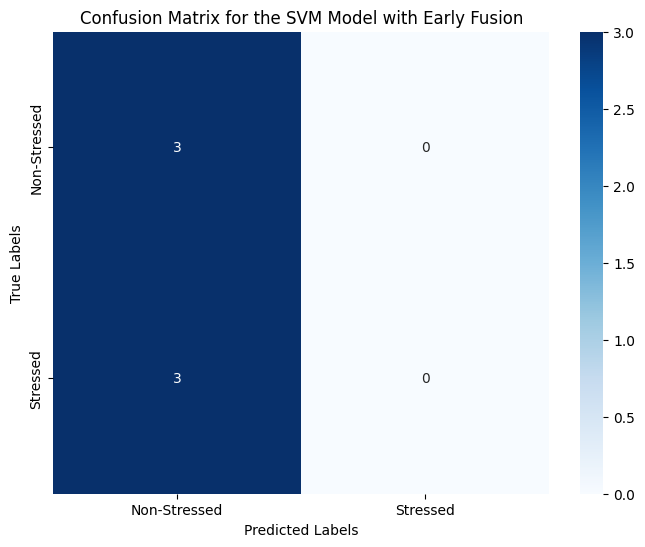

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have your true labels (y_test) and predicted labels (y_pred)
# Replace y_test and y_pred with your actual variables
# y_test = [actual_labels]
# y_pred = [predicted_labels]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Stressed', 'Stressed'], 
            yticklabels=['Non-Stressed', 'Stressed'])
plt.title('Confusion Matrix for the SVM Model with Early Fusion')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the figure to a file
plt.savefig('confusion_matrix.png', dpi=300)

# Show the plot (optional)
plt.show()


In [12]:
from collections import Counter

# Assuming y is your array of labels (0 = non-stressed, 1 = stressed)
label_distribution = Counter(y)

# Output the number of samples in each class
print("Number of non-stressed samples (label 0):", label_distribution[0])
print("Number of stressed samples (label 1):", label_distribution[1])


Number of non-stressed samples (label 0): 17
Number of stressed samples (label 1): 12
